# Operator Inference with Optimization for Energy-Preserving Burger's Equation

Here we implment the operator inference solved with a non-constrained optimization approach rather than a linear least square approach shown in notebook 02. This is the reproduction of the results from [Peherstorfer and Willcox](https://www.sciencedirect.com/science/article/pii/S0045782516301104?via%3Dihub). With the Burgers' equation developed in the paper by [H. Aref and P. K. Daripa](https://epubs.siam.org/doi/10.1137/0905060).

## Packages

In [1]:
using DataFrames
using FileIO
using JLD2
using LaTeXStrings
using LinearAlgebra
using Plots
using Random
using SparseArrays
using Statistics
using NaNStatistics

include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.15, 1.0],
    2^(-7), 1e-4, 1, "periodic"
)
burger.IC = sin.(2 * pi * burger.x)
# ic_a = [0.95, 1.0, 1.05]
ic_a = 1.0
num_ICs = length(ic_a)

# Minimum and maximum dimensions
rmin = 1
rmax = 15

burger_system = LnL.sys_struct(
    is_lin=true,
    is_quad=true,
)
burger_vars = LnL.vars(
    N=1,
)
burger_data = LnL.data(
    Δt=1e-4,
    DS=100,
)
burger_optim = LnL.opt_settings(
    verbose=true,
    initial_guess=false,
    max_iter=5000,
    # reproject=false,
)

# Values to store 
proj_err = zeros(rmax - rmin + 1, 1)
intru_state_err = zeros(rmax - rmin + 1, 1)
ls_state_err = zeros(rmax - rmin + 1, 1)
ephec_state_err = zeros(rmax - rmin + 1, 1)
epsic_state_err = zeros(rmax - rmin + 1, 1)
epuc_state_err = zeros(rmax - rmin + 1, 1)
intru_cr = zeros(rmax - rmin + 1, 1)
ls_cr = zeros(rmax - rmin + 1, 1)
ephec_cr = zeros(rmax - rmin + 1, 1)
epsic_cr = zeros(rmax - rmin + 1, 1)
epuc_cr = zeros(rmax - rmin + 1, 1)
intru_mmt = zeros(rmax - rmin + 1, 1)
ls_mmt = zeros(rmax - rmin + 1, 1)
ephec_mmt = zeros(rmax - rmin + 1, 1)
epsic_mmt = zeros(rmax - rmin + 1, 1)
epuc_mmt = zeros(rmax - rmin + 1, 1)

# Downsampling rate
DS = burger_data.DS

Tdim_ds = size(1:DS:burger.Tdim, 1)  # downsampled time dimension
;

In [ ]:
@info "Generate testing data"
## Create testing data
A, F = burger.generateEPmatrix(burger, burger.μs[1])
Xtest = burger.semiImplicitEuler(A, F, burger.t, burger.IC)
op_burger = LnL.operators(A=A, F=F)


@info "Generate training data for inferred dynamical models"
## training data for inferred dynamical models
Xall = Vector{Matrix{Float64}}(undef, num_ICs)
Xdotall = Vector{Matrix{Float64}}(undef, num_ICs)
for j in 1:num_ICs
    states = burger.semiImplicitEuler(A, F, burger.t, ic_a[j] * burger.IC)
    tmp = states[:, 2:end]
    Xall[j] = tmp[:, 1:DS:end]  # downsample data
    tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
    Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
end
X = reduce(hcat, Xall)
R = reduce(hcat, Xdotall)
# XR = hcat(X, R)

# compute the POD basis from the training data
tmp = svd(X)
Vrmax = tmp.U[:, 1:rmax]
;

In [ ]:
@info "Compute the intrusive model"
options = LnL.LS_options(
    system=burger_system,
    vars=burger_vars,
    data=burger_data,
    optim=burger_optim,
    λ = 0.0,                  # Tikhonov regularization parameter
    pinv_tol = 1e-6,          # tolerance for pseudo-inverse
)

# Compute the values for the intrusive model from the basis of the training data
op_int = LnL.intrusiveMR(op_burger, Vrmax, options)
;

In [ ]:
@info "Compute the Least-Squares model"
if options.optim.reproject == false
    op_LS = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, Vrmax' * R, options)
else
    op_LS = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, op_burger, options)
end
;

In [7]:
@info "Compute the EPHEC model"
options = LnL.EPHEC_options(
    system=burger_system,
    vars=burger_vars,
    data=burger_data,
    optim=burger_optim,
    λ_lin = 0,
    λ_quad = 0,
)

# Compute the inferred operators from the training data
if options.optim.reproject == false
    op_ephec = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, Vrmax' * R, options) 
else
    op_ephec = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, op_burger, options) 
end

# op_tmp = LnL.operators()
# for j in rmin:rmax
#     if j == rmin
#         options.optim.initial_guess = false
#         op_tmp = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax[:,1:j], Vrmax[:,1:j]' * R, options)
#     else
#         options.optim.initial_guess = true
#         op_tmp = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax[:,1:j], Vrmax[:,1:j]' * R, options, op_tmp)
#     end

#     if j != rmax
#         op_tmp.A = [op_tmp.A zeros(j, 1); zeros(1, j+1)]
#         op_tmp.F = Matrix(LnL.insert2F(op_tmp.F, j+1))
#     else
#         op_ephec = op_tmp
#     end
# end

;

┌ Info: Compute the EPHEC model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


In [6]:
@info "Compute the EPSIC OpInf."

options = LnL.EPSIC_options(
    system=burger_system,
    vars=burger_vars,
    data=burger_data,
    optim=burger_optim,
    ϵ=1e-2,
)

if options.optim.reproject == false
    op_epsic = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, Vrmax' * R, options)
else
    op_epsic = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, op_burger, options)
end
;

┌ Info: Compute the EPSIC OpInf.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:396


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:479
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:481


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3600
Number of nonzeros in Lagrangian Hessian.............:   137700

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1360
        inequality constraints with only lower bounds:      680
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      680

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1734389e+04 0.00e+00 1.83e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Soft Inequality Constraint
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = true
│ order                = 15
│ solve time           = 1.6370000839233398
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 21734.388381110162
│ objective_value      = 7.2222120217592045e-6
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:483
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:503


In [7]:
@info "Compute the EPUC OpInf."

options = LnL.EPUC_options(
    system=burger_system,
    vars=burger_vars,
    data=burger_data,
    optim=burger_optim,
    α=1e8,
)

if options.optim.reproject == false
    op_epuc = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, Vrmax' * R, options)
else
    op_epuc = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, op_burger, options)
end
;

┌ Info: Compute the EPUC OpInf.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:531


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:594
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:596


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1734389e+04 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ EP Weight            = 1.0e8
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = true
│ order                = 15
│ solve time           = 1.9500000476837158
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 21734.38883657422
│ objective_value      = -0.00011372881927734188
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:598
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:619


In [11]:
@info "Compute the errors"
for j = rmin:rmax
    Vr = Vrmax[:, 1:j]  # basis

    # Projection Error
    proj_err[j-rmin+1] = LnL.compProjError(Xtest, Vr)
    
    # Intrusive model
    Fint_extract = LnL.extractF(op_int.F, j)
    Xint = burger.semiImplicitEuler(op_int.A[1:j, 1:j], Fint_extract, burger.t, Vr' * burger.IC)  # use F
    intru_state_err[j-rmin+1] = LnL.compStateError(Xtest, Xint, Vr)
    intru_cr[j-rmin+1], intru_mmt[j-rmin+1] = LnL.constraintResidual(Fint_extract, j, options.optim.which_quad_term)

    # Least-Squares model
    Fls_extract = LnL.extractF(op_LS.F, j)
    Xls = burger.semiImplicitEuler(op_LS.A[1:j, 1:j], Fls_extract, burger.t, Vr' * burger.IC)  # use F
    ls_state_err[j-rmin+1] = LnL.compStateError(Xtest, Xls, Vr)
    ls_cr[j-rmin+1], ls_mmt[j-rmin+1] = LnL.constraintResidual(Fls_extract, j, options.optim.which_quad_term)
    
    # Integrate the ephec model
    Fephec_extract = LnL.extractF(op_ephec.F, j)
    Xephec = burger.semiImplicitEuler(op_ephec.A[1:j, 1:j], Fephec_extract, burger.t, Vr' * burger.IC)  # use F
    ephec_state_err[j-rmin+1] = LnL.compStateError(Xtest, Xephec, Vr)
    ephec_cr[j-rmin+1], ephec_mmt[j-rmin+1] = LnL.constraintResidual(Fephec_extract, j, options.optim.which_quad_term)

    # Integrate the epsic model
    Fepsic_extract = LnL.extractF(op_epsic.F, j)
    Xepsic = burger.semiImplicitEuler(op_epsic.A[1:j, 1:j], Fepsic_extract, burger.t, Vr' * burger.IC)  # use F
    epsic_state_err[j-rmin+1] = LnL.compStateError(Xtest, Xepsic, Vr)
    epsic_cr[j-rmin+1], epsic_mmt[j-rmin+1] = LnL.constraintResidual(Fepsic_extract, j, options.optim.which_quad_term)
    
    # Integrate the epuc model
    Fepuc_extract = LnL.extractF(op_epuc.F, j)
    Xepuc = burger.semiImplicitEuler(op_epuc.A[1:j, 1:j], Fepuc_extract, burger.t, Vr' * burger.IC)  # use F
    epuc_state_err[j-rmin+1] = LnL.compStateError(Xtest, Xepuc, Vr)
    epuc_cr[j-rmin+1], epuc_mmt[j-rmin+1] = LnL.constraintResidual(Fepuc_extract, j, options.optim.which_quad_term)
end

┌ Info: Compute the errors
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


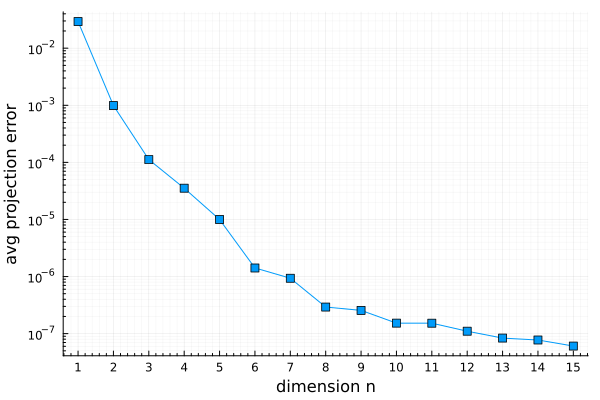

In [12]:
# Projection error
plot(rmin:rmax, proj_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(proj_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("avg projection error")

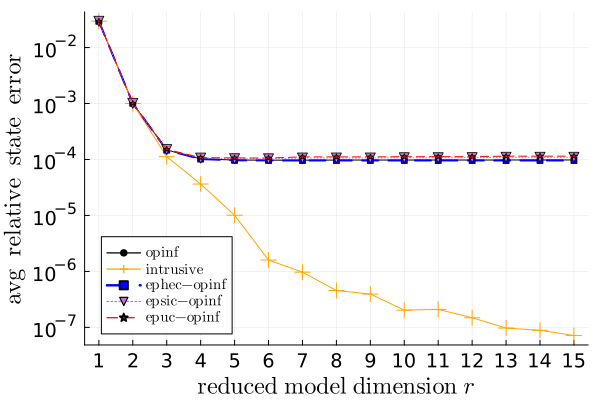

In [13]:
# State errors
plot(rmin:rmax, ls_state_err, c=:black, marker=(:circle, 3.5), label=L"\mathrm{opinf}")
plot!(rmin:rmax, intru_state_err, c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
plot!(rmin:rmax, ephec_state_err, c=:blue, marker=(:rect, 3), ls=:dash, lw=2, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, epsic_state_err, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, epuc_state_err, c=:red, marker=(:star, 3), ls=:dash, lw=1, label=L"\mathrm{epuc}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomleft)
tmp = log10.(intru_state_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!(L"\mathrm{reduced~model~dimension~} r")
ylabel!(L"\mathrm{avg~~relative~~state~~error}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=10, legend=:bottomleft)

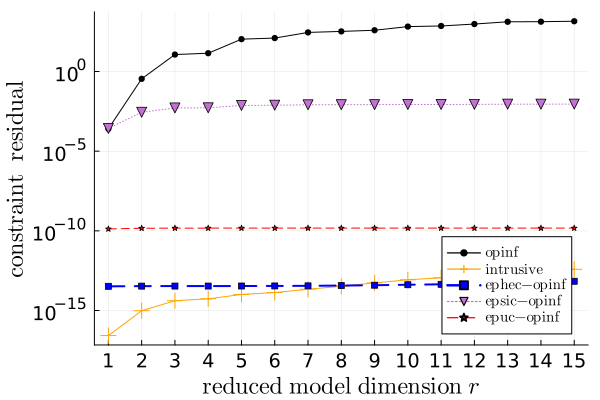

In [14]:
# Constraint residuals
plot(rmin:rmax, ls_cr, marker=(:circle, 3.5), c=:black, label=L"\mathrm{opinf}")
plot!(rmin:rmax, intru_cr, c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
plot!(rmin:rmax, ephec_cr, c=:blue, marker=(:rect, 3), lw=2, ls=:dash, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, epsic_cr, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, epuc_cr, c=:red, marker=(:star, 3), lw=1, ls=:dash, label=L"\mathrm{epuc}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomright, minorgridalpha=0.03)
yticks!(10.0 .^ [-25, -20, -15, -10, -5, 0, 5])
xticks!(rmin:rmax)
xlabel!(L"\mathrm{reduced~model~dimension}~r")
ylabel!(L"\mathrm{constraint~~residual}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=10)

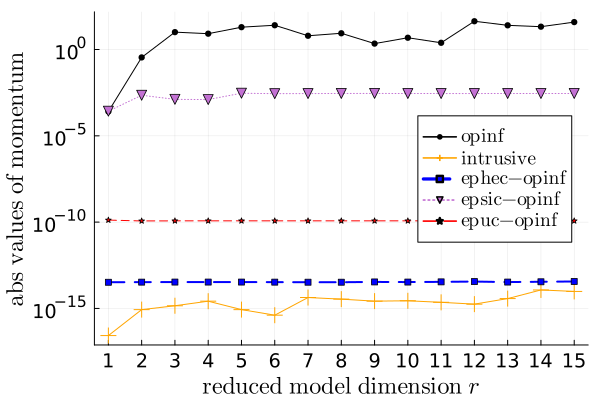

In [21]:
# Momentum
plot(rmin:rmax, abs.(ls_mmt), marker=(:circle, 3.5), c=:black, label=L"\mathrm{opinf}")
plot!(rmin:rmax, abs.(intru_mmt), c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
plot!(rmin:rmax, abs.(ephec_mmt), c=:blue, marker=(:rect, 3), lw=2, ls=:dash, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, abs.(epsic_mmt), marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, abs.(epuc_mmt), c=:red, marker=(:star, 3), lw=1, ls=:dash, label=L"\mathrm{epuc}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomright, minorgridalpha=0.03)
yticks!(10.0 .^ [-15, -10, -5, 0, 5])
xticks!(rmin:rmax)
xlabel!(L"\mathrm{reduced~model~dimension}~r")
ylabel!(L"\mathrm{abs~values~of~momentum}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13, legend=:right)